In [1]:
from datasets import load_dataset
from gensim.corpora import Dictionary  # Mapeo entre palabras e ids
from gensim.models import LdaModel  # Cargar modeo LDA
from gensim.parsing.preprocessing import STOPWORDS  # Lista de palabras de parada
from gensim.test.utils import datapath  # Utilidad para guardar y cargar modelos
from gensim.utils import (
    simple_preprocess,
)  # Convertir un documento en una lista de tokens
import nltk  # Natural Language Toolkit
from nltk.stem import WordNetLemmatizer  # Lematizado
import os
import matplotlib.pyplot as plt
import numpy as np
import requests
from bs4 import BeautifulSoup
import pandas
import torch
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM, AutoModelForQuestionAnswering
# Descargamos información de WordNet para el lematizado
nltk.download("wordnet")

c:\Users\berna\OneDrive\Escritorio\master_ia\APLN\APLN\.env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\berna\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
dataset = load_dataset("glnmario/news-qa-summarization", split="train")

## WordCloud Generation

In [ ]:
stories = list()
for article in dataset:
    stories.append(article["story"])

In [ ]:
def preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 3:
            result.append(WordNetLemmatizer().lemmatize(token))
    return result
processed_docs = [preprocess(story) for story in stories]

In [ ]:
dictionary = Dictionary(processed_docs)
corpus = [dictionary.doc2bow(story) for story in processed_docs]

able action actor afghan afghan afghan afghan afghan afghan afghan afghan afghan afghan afghan afghan afghan afghanistan afghanistan afghanistan afghanistan afghanistan afghanistan afghanistan afghanistan afghanistan afghanistan alleyway approach army army army army army aroma asylum asylum authorized baking banter battalion battered bazaar beam beria beria best better british british british british british british british british british british british build business center changing clearly closest clothes colthup colthup come comfortable complex complex compound conduct cost count countryside course creating creating cross cultural cultural culture culture culture david difficult directly distinctive duty easily easy elder elder elder england england english entering environment exercise explains explains farmhouse farmhouse fazel feature fight flatbread fled force force force freshly ghurkha give going grape green grilled ground ground group hand handle hawk heart helmand helmand 

In [ ]:
lda_model = LdaModel(
        corpus=corpus,  # El conjunto de datos
        id2word=dictionary,  # Diccionario que mapea cada palabra a un identificador único
        num_topics=10,  # Número de temas que queremos identificar
        random_state=666,  # Establecemos una semilla para reproducibilidad
        update_every=1,  # Cada cuantos documentos se actualizan los parámetros del modelo
        passes=15,  # Núero de pases sobre el corpus completo. Más pases implica más precisión, pero más tiempo de entrenamiento
        alpha="auto",  # Cantidad de temas que habrá en los documentos (si normalmente habrán pocos o muchos)
        per_word_topics=True,
    )

In [ ]:
topics = lda_model.print_topics(num_words=6)
for topic in topics:
    print(topic)

(0, '0.032*"said" + 0.015*"military" + 0.014*"official" + 0.010*"attack" + 0.010*"force" + 0.009*"afghanistan"')
(1, '0.020*"child" + 0.018*"said" + 0.017*"school" + 0.012*"health" + 0.011*"student" + 0.010*"woman"')
(2, '0.032*"said" + 0.014*"court" + 0.009*"year" + 0.009*"case" + 0.007*"told" + 0.007*"family"')
(3, '0.019*"said" + 0.008*"people" + 0.008*"church" + 0.007*"group" + 0.007*"government" + 0.007*"country"')
(4, '0.009*"year" + 0.009*"like" + 0.007*"time" + 0.007*"people" + 0.006*"say" + 0.005*"world"')
(5, '0.012*"team" + 0.010*"game" + 0.010*"world" + 0.010*"year" + 0.009*"player" + 0.008*"second"')
(6, '0.048*"said" + 0.013*"police" + 0.008*"people" + 0.006*"home" + 0.006*"told" + 0.006*"city"')
(7, '0.018*"said" + 0.013*"iran" + 0.012*"government" + 0.011*"state" + 0.010*"election" + 0.010*"country"')
(8, '0.031*"said" + 0.020*"flight" + 0.016*"plane" + 0.012*"airport" + 0.011*"pilot" + 0.010*"airline"')
(9, '0.021*"said" + 0.016*"obama" + 0.014*"president" + 0.009*"sta

In [ ]:
# Asignamos los temas a cada documento en el corpus
topics_dict = dict()
for document_num, doc in enumerate(corpus):
  # Obtenemos las distribución de temas para el documento
  doc_topics, word_topics, phi_values = lda_model.get_document_topics(doc, per_word_topics=True)
  
  # Ordenamos por el segundo elemento de la tupla (probabilidad del tema) y obtenemos el mayor
  dominant_topic = sorted(doc_topics, key=lambda x: x[1], reverse=True)[0]
  topic_num, prop_topic = dominant_topic

  # Crear una lista vacía para almacenar las palabras del documento
  document_words = []

  # Recorrer cada par (id de palabra, frecuencia) en la representación BoW
  for word_id, freq in doc:
    # Obtener la palabra correspondiente al id del diccionario
    word = dictionary[word_id]
    
    # Agregar la palabra a la lista de palabras del documento, repetida según su frecuencia
    document_words.extend([word] * freq)
  # Unir las palabras en un solo string, separadas por espacios
  document = ' '.join(document_words)
  # Guardado de texto por tema
  if topic_num in topics_dict:
    topics_dict[topic_num] += document
  else:
    topics_dict[topic_num] = document

In [ ]:
from wordcloud import WordCloud
os.makedirs("wordclouds", exist_ok=True)

for topic_num, words in topics_dict.items():
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = STOPWORDS,
                collocations=False, 
                min_font_size = 10).generate(words)
    wordcloud.to_file(f"wordclouds/topic_{topic_num}.png")

## Data Features

In [3]:
stories = [x['story'] for x in dataset]
questions = [x['questions'] for x in dataset]
answers = [x['answers'] for x in dataset]
summary = [x['summary'] for x in dataset]

In [4]:
lens = [len(x) for x in stories]
max_len = np.max(lens)
mean_len = int(np.mean(lens))
min_len = np.min(lens)
print(f'Max words in a story: {max_len}')
print(f'Mean words in a story: {mean_len}') 
print(f'Min words in a story: {min_len}')

Max words in a story: 4551
Mean words in a story: 3065
Min words in a story: 117


([<matplotlib.patches.Wedge at 0x2118038aa10>,
 [Text(1.0980483471625597, 0.06549677315388193, '0-1000'),
  Text(0.8710998563533531, 0.6717030893640192, '1000-2000'),
  Text(-0.35796419763771603, 1.040125777591146, '2000-3000'),
  Text(-0.7899528023272201, -0.7654897583216721, '3000-4000'),
  Text(0.9461314015670416, -0.5611019256505771, '4000-5000')],
 [Text(0.8484919046256142, 0.050611142891636034, '1.9%'),
  Text(0.6731226162730455, 0.5190432963267421, '17.1%'),
  Text(-0.27660869817459877, 0.8037335554113401, '22.5%'),
  Text(-0.6104180745255792, -0.5915148132485648, '41.4%'),
  Text(0.731101537574532, -0.4335787607299914, '17.0%')])

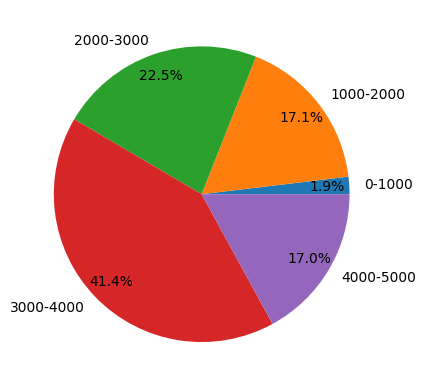

In [5]:
to_1000 = [x for x in lens if x <= 1000]
to_2000 = [x for x in lens if x > 1000 and x <= 2000] 
to_3000 = [x for x in lens if x > 2000 and x <= 3000] 
to_4000 = [x for x in lens if x > 3000 and x <= 4000] 
to_5000 = [x for x in lens if x > 4000 and x <= 5000] 
dist_lens = [to_1000, to_2000, to_3000, to_4000, to_5000]

labels = ["0-1000", "1000-2000", "2000-3000", "3000-4000", "4000-5000"]
sizes = [len(x) for x in dist_lens]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', pctdistance=0.85)


In [6]:
num_questions = [len(x) for x in questions]
max_len = np.max(num_questions)
mean_len = int(np.mean(num_questions))
min_len = np.min(num_questions)
print(f'Max number of questions: {max_len}')
print(f'Mean number of questions: {mean_len}') 
print(f'Min number of questions: {min_len}')

Max number of questions: 39
Mean number of questions: 6
Min number of questions: 1


In [7]:
num_answers = [len(x) for x in answers]
max_len = np.max(num_answers)
mean_len = int(np.mean(num_answers))
min_len = np.min(num_answers)
print(f'Max number of answers: {max_len}')
print(f'Mean number of answers: {mean_len}') 
print(f'Min number of answers: {min_len}')

Max number of answers: 39
Mean number of answers: 6
Min number of answers: 1


In [8]:
len_answers = list()
for x in answers:
    for y in x:
        len_answer = len(str(y).split("[")[1].split("]")[0].split(" "))
        len_answers.append(len_answer)
print("Average number of words per answer: ", int(np.mean(len_answers)))
print("Maximum number of words per answer: ", np.max(len_answers))
print("Minimum number of words per answer: ", np.min(len_answers))

Average number of words per answer:  4
Maximum number of words per answer:  87
Minimum number of words per answer:  1


In [9]:
summary_lens = [len(x) for x in summary]
max_len = np.max(summary_lens)
mean_len = int(np.mean(summary_lens))
min_len = np.min(summary_lens)
print(f'Max words in a summary: {max_len}')
print(f'Mean words in a summary: {mean_len}') 
print(f'Min words in a summary: {min_len}')

Max words in a summary: 465
Mean words in a summary: 264
Min words in a summary: 65


## Web Scrapping

In [3]:
# Obtener todos los enlaces de cnn.com
all_urls = list()
url = "https://www.cnn.com"
data = requests.get(url).text
soup = BeautifulSoup(data, features="html.parser")
for a in soup.find_all('a', href=True):
    if a['href'] and a['href'][0] == '/' and a['href'] != '#':
        # Incluir el dominio y protocolo
        a['href'] = url + a['href']
    all_urls.append(a['href'])

In [4]:
print(len(all_urls))

421


In [5]:
def url_is_article(url, current_year='2024'):
    if url:
        if 'cnn.com/{}/'.format(current_year) in url and '/gallery/' not in url:
            return True
    return False

article_urls = [url for url in all_urls if url_is_article(url)]

In [13]:
def return_text_if_not_none(element):
    if element:
        return element.text.strip()
    else:
        return ''
def parse(html):
    soup = BeautifulSoup(html, features="html.parser")
    article_content = soup.find_all('p', class_ ='paragraph inline-placeholder')
    article_text = [return_text_if_not_none(p) for p in article_content]
    return article_text

In [14]:
articles_content = list()
for url in article_urls:
    data = requests.get(url).text
    articles_content.append(parse(data))

In [15]:
processed_articles = list()
aux_text = ""
for article in articles_content:
    for element in article:
        aux_text += element
    processed_articles.append(aux_text)
    aux_text = "" 

## Features Generation

In [16]:
summaries = list()
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")

In [17]:
for article in processed_articles:
    input_text = article
    input_ids = tokenizer(input_text, return_tensors="pt", truncation=True).input_ids

    outputs = model.generate(input_ids)
    summaries.append(tokenizer.decode(outputs[0]).split("</s>")[1].split("<s>")[1])

In [19]:
print(summaries[1])

Leo Varadkar resigns as Ireland's Prime Minister. He said he was "no longer the best person" to lead his country. The 45-year-old had become a familiar face on the international stage. He became the youngest prime minister in Irish history in 2017.


In [31]:
dict = {'story': processed_articles, 'summary': summaries} 
    
df = pandas.DataFrame(dict)
    
df.to_csv('articles.csv')

In [15]:
file_csv = pandas.read_csv('articles.csv')
processed_articles = file_csv['story'].tolist()
summaries = file_csv['summary'].tolist()

In [7]:
questions = list()

In [10]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2")
model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 2/2 [01:20<00:00, 40.30s/it]


In [33]:
for summary in summaries:
    input_text = "Generate 1 question about the following text: " + summary
    input_ids = tokenizer(input_text, return_tensors="pt", truncation=True).input_ids

    outputs = model.generate(input_ids, max_length=(len(input_text) + 25))
    questions.append(tokenizer.decode(outputs[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

In [66]:
questions_preprocessed = list()
for question in questions:
    if "A: " in question:
        questions_preprocessed.append(question.split("A: ")[1].split("<|endoftext|>")[0])
    elif "Answer: " in question:
        questions_preprocessed.append(question.split("Answer: ")[1].split("<|endoftext|>")[0])
    elif "ANSWER: " in question:
        questions_preprocessed.append(question.split("ANSWER: ")[1].split("<|endoftext|>")[0])
    elif "the question is: " in question:
            questions_preprocessed.append(question.split("the question is: ")[1].split("<|endoftext|>")[0])
    elif "The question is: " in question:
            questions_preprocessed.append(question.split("The question is: ")[1].split("<|endoftext|>")[0])
    elif "Output: " in question:
            questions_preprocessed.append(question.split("Output: ")[1].split("<|endoftext|>")[0])
    elif "AI: " in question:
            questions_preprocessed.append(question.split("AI: ")[1].split("<|endoftext|>")[0])
    

In [77]:
print(len(questions_preprocessed))

98


In [79]:
cont = 0
index = 0
rows_to_remove = list()
for question in questions:
        if "A: " in question or "Answer: " in question or "ANSWER: " in question or "the question is: " in question or "The question is: " in question or "Output: " in question or "AI: " in question:
            cont = cont + 1
        else:
            rows_to_remove.append(index)
            print(index)
            # print(question)
        index = index + 1
print(cont)

65
84
95
98


In [80]:
for index in rows_to_remove:
    processed_articles.pop(index)
    summaries.pop(index)

In [83]:
dict = {'story': processed_articles, 'summary': summaries, 'questions': questions_preprocessed} 
    
df = pandas.DataFrame(dict)
    
df.to_csv('articles2.csv')

In [84]:
answers = list()
question_answerer = pipeline("question-answering", model="deepset/roberta-base-squad2")

c:\Users\berna\OneDrive\Escritorio\master_ia\APLN\APLN\.env\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\berna\.cache\huggingface\hub\models--deepset--roberta-base-squad2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [90]:
for i in range(len(processed_articles)):
    answers.append(question_answerer(
        question = questions_preprocessed[i],
        context = processed_articles[i]
    )['answer'])

In [106]:
file_csv = pandas.read_csv('train.csv')
processed_articles = file_csv['story'].tolist()
summaries = file_csv['summary'].tolist()
answers = file_csv['answers'].tolist()
questions = file_csv['questions'].tolist()

In [110]:
def eliminar_duplicados(lista):
    elementos_unicos = {}
    for i, elemento in enumerate(lista):
        if elemento not in elementos_unicos:
            elementos_unicos[elemento] = [i]
        else:
            elementos_unicos[elemento].append(i)

    lista_unica = list(elementos_unicos.keys())

    indices_por_elemento = list(elementos_unicos.values())

    return lista_unica, indices_por_elemento

lista_unica, indices_por_elemento = eliminar_duplicados(processed_articles)

print("Lista única:", lista_unica)
print("Índices por elemento:", indices_por_elemento)

Lista única: ['The announcement from Catherine, Princess of Wales that she has started chemotherapy for cancer and is in the “early stages of that treatment” was a bolt from the blue.As Britain woke up on Saturday morning, the tone of every major newspaper was of concern. The Times struck a reassuring note with its front page headline, “Princess reveals her cancer and says: I’m going to be OK.” The FT Weekend opted for “Kate puts end to speculation” while The Sun tabloid told the princess, “KATE, YOU ARE NOT ALONE”The 42-year-old princess revealed her cancer battle a day earlier in an emotional video statement, after weeks of relentless scrutiny over her health.It was a bold move. This is someone who gets nervous speaking in front of cameras, let alone about such a deeply personal matter. But the video – simply shot, on a bench in front of a spray of spring foliage – showed Kate earnestly sharing her  story on her own terms and in her own words.It was powerful to hear her speak so plai

In [123]:
keep = list()
for indice in indices_por_elemento:
    keep.append(indice[0])
print(keep)
print(len(keep))

[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 15, 17, 18, 19, 20, 21, 22, 23, 24, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 70, 72, 73, 74, 75, 77, 78, 79, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]
73


In [117]:
train_articles = list()
train_summaries = list()
train_questions = list()
train_answers = list()
for elem in keep:
    train_articles.append(processed_articles[elem])
    train_summaries.append(summaries[elem])
    train_questions.append(questions[elem])
    train_answers.append(answers[elem])

In [131]:
train_questions_processed = list()
for question in train_questions:
    train_questions_processed.append([question.split("\n")[0]])

['What is the name of the late Nicholas Hotton III who first uncovered the fossil of Kermitops gratus?']


In [133]:
train_answers_processed = list()
for answer in train_answers:
    train_answers_processed.append([[answer]])

[['Catherine']]


## Merge Dataset

In [134]:
dict = {'story': train_articles,'questions': train_questions_processed, 'answers': train_answers_processed, 'summary': train_summaries} 
    
df = pandas.DataFrame(dict)
    
df.to_csv('train.csv', index=False)